In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

#df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
df = pd.read_csv("BTC-USD.csv")
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["Close"])
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


c:\Users\ivoto\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


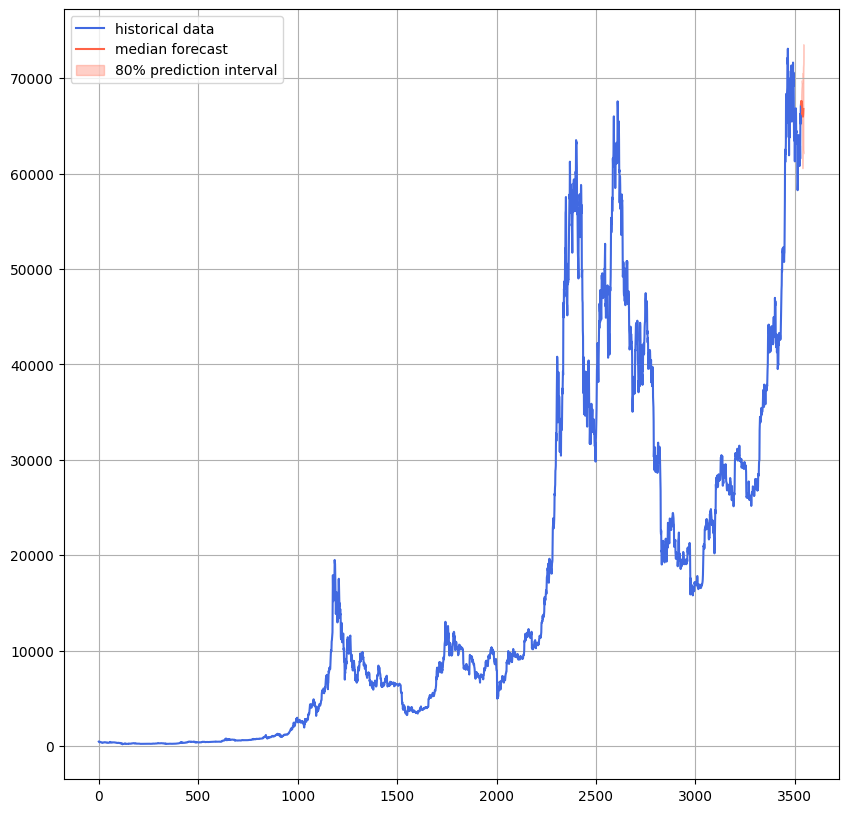

In [6]:
plt.figure(figsize=(10, 10))
plt.plot(df["Close"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()


c:\Users\ivoto\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


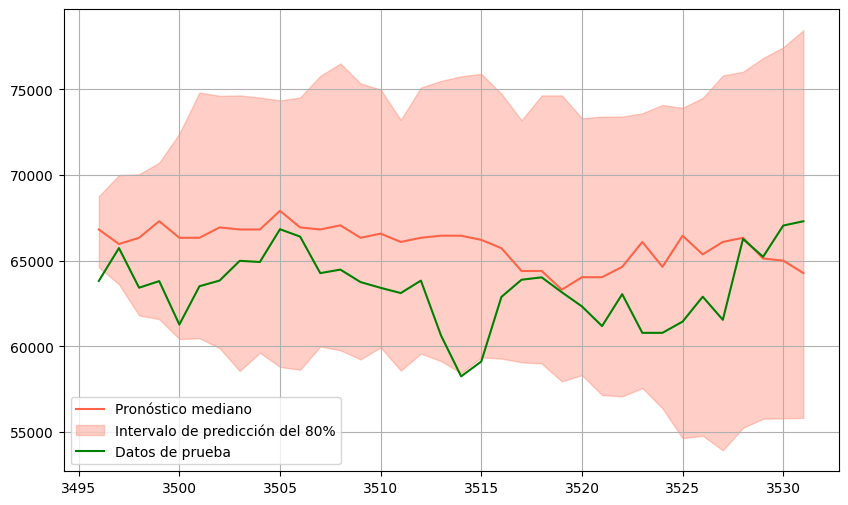

Mean Squared Error: 11335690.07712423


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from sklearn.metrics import mean_squared_error

# Función para visualizar pronósticos centrados en los datos de prueba
def plot_forecast(test_data, forecast_index, median, low, high):
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_index, median, color="tomato", label="Pronóstico mediano")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="Intervalo de predicción del 80%")
    plt.plot(forecast_index, test_data.values, color="green", label="Datos de prueba")
    plt.legend()
    plt.grid()
    plt.show()

# Cargar los datos
df = pd.read_csv("BTC-USD.csv")

# Dividir el conjunto de datos en entrenamiento y prueba
train_size = int(len(df) * 0.99)  # 99% para entrenamiento, 1% para prueba
train_data = df["Close"][:train_size]
test_data = df["Close"][train_size:]

# Convertir los datos de entrenamiento a tensor 1D
context = torch.tensor(train_data.values, dtype=torch.bfloat16)

# Establecer prediction_length y desactivar la verificación de longitud si es necesario
prediction_length = min(len(test_data), 64)  # Limitar la longitud de predicción a 64

# Cargar el modelo de Chronos
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

# Hacer la predicción
forecast = pipeline.predict(context, prediction_length, limit_prediction_length=False)  # forma [num_series, num_samples, prediction_length]

# Índices para el pronóstico
forecast_index = range(train_size, train_size + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Visualizar el pronóstico centrado en los datos de prueba
plot_forecast(test_data[:prediction_length], forecast_index, median, low, high)

# Asegurarse de que no haya NaNs en los datos de prueba y en las predicciones
test_data_clean = test_data[:prediction_length].dropna()
median_forecast_clean = pd.Series(median, index=forecast_index).dropna()

# Asegurarse de que las longitudes coinciden después de eliminar NaNs
min_length = min(len(test_data_clean), len(median_forecast_clean))
test_data_clean = test_data_clean[:min_length]
median_forecast_clean = median_forecast_clean[:min_length]

# Evaluar la precisión de las predicciones
mse = mean_squared_error(test_data_clean, median_forecast_clean)
print(f"Mean Squared Error: {mse}")

